## Import Libraries

In [1]:
!pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import ast
import torch
import random
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
#from torch.serialization import add_safe_globals
from torch_geometric.nn import GATv2Conv, SAGEConv, GCNConv
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#RUN_PATH = '/content/drive/MyDrive/raw_graph'
RUN_PATH = './raw_graph_clustered'

## Parse Files

In [2]:
def parse_formatted(filepath):
    globals_ = {}
    bounds = {}
    with open(filepath, 'r') as f:
        lines = f.read().splitlines()
    f.close()
    for l in lines:
        if '=' in l:
            key, val = l.split('=', 1)
            key = key.strip()
            if key in {'lx', 'ly', 'ux', 'uy'}:
                bounds[key] = float(val.strip())
            else:
                globals_[key] = float(val.strip())
    records = [ast.literal_eval(l) for l in lines if l.strip().startswith('{')]
    drivers = [r['driver']['id'] for r in records]
    sinks = [s['id'] for r in records for s in r['sinks']]
    node_ids = sorted(set(drivers + sinks))
    return node_ids, records, globals_, bounds

def parse_label_formatted(label_path, node_ids, bounds):
    lines = []
    with open(label_path, 'r') as f:
        for row in f:
            parts = row.strip().split()
            if len(parts) == 3 and parts[0].isdigit():
                lines.append((int(parts[0]), float(parts[1]), float(parts[2])))
    f.close()
    ids, xs, ys = zip(*lines)
    xs = np.array(xs)
    ys = np.array(ys)
    lx, ly, ux, uy = bounds['lx'], bounds['ly'], bounds['ux'], bounds['uy']

    x_norm = (xs - lx) / (ux - lx)
    y_norm = (ys - ly) / (uy - ly)

    # clamp if outside lower or upper bound
    x_norm = np.clip(x_norm, 0.0, 1.0)
    y_norm = np.clip(y_norm, 0.0, 1.0)
    # map back to node order
    id2coord = {i: (x_norm[idx], y_norm[idx]) for idx, i in enumerate(ids)}
    coords = [id2coord.get(nid, (0.0, 0.0)) for nid in node_ids]
    return torch.tensor(coords, dtype=torch.float)


## Matrix/Feature Generation and Relative Loss

In [3]:
def build_edge_index(node_ids, records, bidirectional=True):
    id2idx = {nid: i for i, nid in enumerate(node_ids)}
    edges = []
    for r in records:
        d = id2idx[r['driver']['id']]
        for s in r['sinks']:
            sid = id2idx[s['id']]
            edges.append((d, sid))
            if bidirectional:
                edges.append((sid, d))
    if not edges:
        return torch.empty((2, 0), dtype=torch.long)
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def build_adjacency(N, edge_index):
    src, dst = edge_index.cpu().numpy()
    return csr_matrix((np.ones(len(src)), (src, dst)), shape=(N, N))

def fix_signs(eigvecs):
    for i in range(eigvecs.shape[1]):
        if np.abs(eigvecs[:, i]).sum() == 0:
            continue
        if eigvecs[np.argmax(np.abs(eigvecs[:, i])), i] < 0:
            eigvecs[:, i] *= -1
    return eigvecs
        
def compute_laplacian_eigenvectors(adj, k=10, normalized=True):
    N = adj.shape[0]
    k_eff = min(k, max(N-1, 0))
    deg = np.array(adj.sum(axis=1)).flatten()
    if normalized:
        inv_s = np.where(deg > 0, 1.0/np.sqrt(deg), 0.0)
        #inv_s = np.zeros_like(deg)
        #nonzero = deg > 0
        #inv_s[nonzero] = 1.0 / np.sqrt(deg[nonzero])
        D = csr_matrix((inv_s, (range(N), range(N))), shape=adj.shape)
        L = csr_matrix(np.eye(N)) - D @ adj @ D
    else:
        D = csr_matrix((deg, (range(N), range(N))), shape=adj.shape)
        L = D - adj
    if k_eff < 1:
        return np.zeros((N, 0), dtype=np.float32)
    try:
        _, vecs = eigsh(L, k=k_eff+1, which='SM')
    except:
        _, vecs = np.linalg.eigh(L.toarray())
        
    #vecs = fix_signs(vecs)
    #scaler = StandardScaler()
    #vecs_norm = scaler.fit_transform(vecs)

    X = vecs  # shape: [num_nodes, 10]
    X_min = np.min(X, axis=0, keepdims=True)  # shape: (1, 10)
    X_max = np.max(X, axis=0, keepdims=True)
    vecs_norm = (X - X_min) / (X_max - X_min + 1e-6)

    return vecs_norm[:, 1:k_eff+1]

def shuffle_nodes(data: Data) -> Data:
    num_nodes = data.num_nodes
    perm = torch.randperm(num_nodes)

    data.x = data.x[perm]
    data.y = data.y[perm]

    if hasattr(data, "node_ids"):
        data.node_ids = torch.tensor(data.node_ids)[perm].tolist()
    
    inv_perm = torch.empty_like(perm)
    inv_perm[perm] = torch.arange(num_nodes)
    data.edge_index = inv_perm[data.edge_index]

    return data

In [4]:
def compute_relative_loss(out, data, criterion):
    edge_index = data.edge_index

    src, tgt = edge_index
    pred_src, pred_tgt = out[src], out[tgt]
    true_src, true_tgt = data.y[src], data.y[tgt]
    pred_dist = torch.norm(pred_src - pred_tgt, dim=1)
    true_dist = torch.norm(true_src - true_tgt, dim=1)

    loss = criterion(pred_dist, true_dist)

    return loss

def soft_density_loss(x, y, cell_area=0.0001, bin_size=0.05, density_threshold=0.4, sigma=0.01):
    device = x.device
    x = torch.clamp(x, 0.0, 1.0)
    y = torch.clamp(y, 0.0, 1.0)
    x_bins = torch.arange(bin_size / 2, 1.0, bin_size, device=device)
    y_bins = torch.arange(bin_size / 2, 1.0, bin_size, device=device)
    x_centers, y_centers = torch.meshgrid(x_bins, y_bins, indexing='ij')

    Bx, By = x_centers.shape
    num_bins = Bx * By

    x_centers_flat = x_centers.flatten().unsqueeze(0)
    y_centers_flat = y_centers.flatten().unsqueeze(0)
    x_expand = x.unsqueeze(1)  # (N, 1)
    y_expand = y.unsqueeze(1)  # (N, 1)

    dx2 = (x_expand - x_centers_flat) ** 2
    dy2 = (y_expand - y_centers_flat) ** 2
    gauss = torch.exp(-(dx2 + dy2) / (2 * sigma**2))  # (N, B)

    density_per_bin = torch.sum(gauss, dim=0) * cell_area  # (B,)
    bin_area = bin_size * bin_size
    density_norm = density_per_bin / bin_area  # (B,)

    penalty = torch.clamp(density_norm - density_threshold, min=0.0)
    loss = penalty.sum()

    return loss

def loss_function(out, data, criterion):
    pred_x, pred_y = out[:, 0], out[:, 1]
    #density = soft_density_loss(pred_x, pred_y, cell_area=0.0001, bin_size=0.05, density_threshold=0.6, sigma=0.01)
    #loss = 0.0 * criterion(out, data.y) + 1.0 * compute_relative_loss(out, data, criterion) + 0.0 * density
    loss = compute_relative_loss(out, data, criterion)
    return loss

## Load Data

In [5]:
def load_all_data(train_dir, test_dir, train_list, test_list, design_filter=[], batch_size=16, shuffle=True):
    train_data_list = []
    test_data_list = []
    #data_list = []
    for dp, _, files in os.walk(train_dir):
        for f in files:
            if not f.endswith('_formatted.txt') or f.endswith('_label_formatted.txt'):
                continue
            curr_file = '_'.join(f.split('_', 3)[:2])
            if design_filter and curr_file not in design_filter:
                continue
            fp = os.path.join(dp, f)
            lf = fp.replace('_formatted.txt', '_label_formatted.txt')
            if not os.path.exists(lf):
                continue
            node_ids, records, globals_, bounds = parse_formatted(fp)
            orig_coords = {rec['driver']['id']:(rec['driver']['x'], rec['driver']['y']) for rec in records}
            for rec in records:
                for s in rec['sinks']:
                    orig_coords[s['id']] = (s['x'], s['y'])
            feats = torch.tensor(
                compute_laplacian_eigenvectors(
                    build_adjacency(len(node_ids), build_edge_index(node_ids, records)), 10
                ), dtype=torch.float
            )
            labels = parse_label_formatted(lf, node_ids, bounds)
            # need to globally normalize these values
            u_vec = torch.tensor([
                (globals_['Core Aspect Ratio'] - 0.4) / 0.5,
                (globals_['Utilization'] - 40.0) / 35.0,
                (globals_['Place Density'] - 0.5) / 0.4, #( range 0.5-0.9)
                (globals_['core_width']/1000000),
                (globals_['core_height']/1000000)
            ], dtype=torch.float).unsqueeze(0)
            edges = build_edge_index(node_ids, records)
            
            fixed_ids = [rec['driver']['id'] for rec in records if rec['driver'].get('is_fixed')]
            fixed_ids += [s['id'] for rec in records for s in rec['sinks'] if s.get('is_fixed')]
            
            is_io = []
            norm_coords = []
            lx, ly, ux, uy = bounds['lx'], bounds['ly'], bounds['ux'], bounds['uy']
            
            for nid in node_ids:
                if nid in fixed_ids:
                    x, y = orig_coords[nid]
                    x = max(0.0, min(1.0, (x - lx) / (ux - lx)))
                    y = max(0.0, min(1.0, (y - ly) / (uy - ly)))
                else:
                    x, y = -1.0, -1.0
            
                norm_coords.append((x, y))
                is_io.append(1.0 if nid in fixed_ids else 0.0)
            
            is_io_tensor = torch.tensor(is_io, dtype=torch.float).unsqueeze(1)
            io_coords_tensor = torch.tensor(norm_coords, dtype=torch.float)
            
            feats = torch.cat([feats, is_io_tensor, io_coords_tensor], dim=1)
            
            data = Data(x=feats, edge_index=edges, u=u_vec, y=labels)
            
            data.design_name = f.replace('_formatted.txt','')
            data.node_ids = node_ids
            data.bounds = bounds
            data.orig_coords = orig_coords
            data.fixed_ids = fixed_ids
            
            data = shuffle_nodes(data)
            data.to(device)
            
            if curr_file in train_list:
                train_data_list.append(data)

            #data_list.append(data)

    for dp, _, files in os.walk(test_dir):
        for f in files:
            if not f.endswith('_formatted.txt') or f.endswith('_label_formatted.txt'):
                continue
            curr_file = '_'.join(f.split('_', 3)[:2])
            #print(curr_file)
            if design_filter and curr_file not in design_filter:
                continue
            fp = os.path.join(dp, f)
            lf = fp.replace('_formatted.txt', '_label_formatted.txt')
            if not os.path.exists(lf):
                continue
            node_ids, records, globals_, bounds = parse_formatted(fp)
            orig_coords = {rec['driver']['id']:(rec['driver']['x'], rec['driver']['y']) for rec in records}
            for rec in records:
                for s in rec['sinks']:
                    orig_coords[s['id']] = (s['x'], s['y'])
            feats = torch.tensor(
                compute_laplacian_eigenvectors(
                    build_adjacency(len(node_ids), build_edge_index(node_ids, records)), 10
                ), dtype=torch.float
            )
            labels = parse_label_formatted(lf, node_ids, bounds)
            # need to globally normalize these values
            u_vec = torch.tensor([
                (globals_['Core Aspect Ratio'] - 0.4) / 0.5,
                (globals_['Utilization'] - 40.0) / 35.0,
                (globals_['Place Density'] - 0.5) / 0.4, #( range 0.5-0.9)
                (globals_['core_width']/1000000),
                (globals_['core_height']/1000000)
            ], dtype=torch.float).unsqueeze(0)
            edges = build_edge_index(node_ids, records)
            
            fixed_ids = [rec['driver']['id'] for rec in records if rec['driver'].get('is_fixed')]
            fixed_ids += [s['id'] for rec in records for s in rec['sinks'] if s.get('is_fixed')]
            
            is_io = []
            norm_coords = []
            lx, ly, ux, uy = bounds['lx'], bounds['ly'], bounds['ux'], bounds['uy']
            
            for nid in node_ids:
                if nid in fixed_ids:
                    x, y = orig_coords[nid]
                    x = max(0.0, min(1.0, (x - lx) / (ux - lx)))
                    y = max(0.0, min(1.0, (y - ly) / (uy - ly)))
                else:
                    x, y = -1.0, -1.0
            
                norm_coords.append((x, y))
                is_io.append(1.0 if nid in fixed_ids else 0.0)
            
            is_io_tensor = torch.tensor(is_io, dtype=torch.float).unsqueeze(1)
            io_coords_tensor = torch.tensor(norm_coords, dtype=torch.float)
            
            feats = torch.cat([feats, is_io_tensor, io_coords_tensor], dim=1)
            
            data = Data(x=feats, edge_index=edges, u=u_vec, y=labels)
            
            data.design_name = f.replace('_formatted.txt','')
            data.node_ids = node_ids
            data.bounds = bounds
            data.orig_coords = orig_coords
            data.fixed_ids = fixed_ids
            
            data = shuffle_nodes(data)
            data.to(device)
            
            if curr_file in test_list:
                test_data_list.append(data)

            #data_list.append(data)


    #train_size = int(0.8 * len(data_list))
    #test_size = len(data_list) - train_size
    #train_data_list, test_data_list = random_split(data_list, [train_size, test_size])

    #if shuffle:
        #random.shuffle(train_data_list)
        #random.shuffle(test_data_list)
        #random.shuffle(data_list)
    return DataLoader(train_data_list, batch_size=batch_size, shuffle=shuffle, exclude_keys=['orig_coords','node_ids','bounds','fixed_ids', 'records']), DataLoader(test_data_list, batch_size=batch_size, shuffle=False, exclude_keys=['orig_coords','node_ids','bounds','fixed_ids', 'records'])
    #return DataLoader(train_data_list, batch_size=batch_size, shuffle=shuffle, exclude_keys=['orig_coords','bounds','fixed_ids', 'records']), DataLoader(test_data_list, batch_size=batch_size, shuffle=False, exclude_keys=['orig_coords','bounds','fixed_ids', 'records'])


## Model

In [6]:
class PositionalEncoder(torch.nn.Module):
    def __init__(self, pe_dim, hidden_dim):
        super().__init__()
        self.pe_mlp = torch.nn.Sequential(
            torch.nn.Linear(pe_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, pe):
        return self.pe_mlp(pe)

In [7]:
class PlacementGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, num_layers=3, global_channels=3, conv_type='sage'):
        super().__init__()
        #self.pos_encoder = PositionalEncoder(pe_dim=in_channels, hidden_dim=64)
        ConvMap = {'gat': GATv2Conv, 'sage': SAGEConv, 'gcn': GCNConv}
        Conv = ConvMap[conv_type]
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(
                Conv(
                    in_channels  if i == 0 else hidden_channels,
                    #hidden_channels,
                    hidden_channels
                )
            )
        self.norm = torch.nn.LayerNorm(hidden_channels)
        self.post_lin = torch.nn.Linear(hidden_channels + global_channels, hidden_channels)
        self.out_lin = torch.nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch, u, edge_attr=None):
        #pe_encoded = self.pos_encoder(x)
        #x = pe_encoded
        for conv in self.convs:
            if isinstance(conv, GATv2Conv):
                x = conv(x, edge_index, edge_attr)
            else:
                x = conv(x, edge_index)
            x = F.relu(x)
        x = self.norm(x)
        u_exp = u[batch]
        h = torch.cat([x, u_exp], dim=1)
        h = F.relu(self.post_lin(h))
        return self.out_lin(h)

## Training

In [8]:
def adjust_learning_rate(optimizer, epoch):
    adjust_list = []
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.8

In [9]:
def train(train_dataset, model, criterion, optimizer, epoch):
    train_loss = 0.0
    model.train()
    for data in train_dataset:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.u)

        loss = loss_function(out, data, criterion)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.num_graphs

    avg_loss = train_loss/len(train_dataset.dataset)

    if (epoch) % 10 == 0:
        print(f'Epoch {epoch} Training loss: MSE: {avg_loss:.4f}')

    return avg_loss

In [10]:
def validate(test_dataset, model, criterion):
    test_loss = 0.0
    coords_x = []
    coords_y = []
    model.eval()
    with torch.no_grad():
        for data in test_dataset.dataset:
            data = data.to(device)

            batch_vec = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
            out = model(data.x, data.edge_index, batch_vec, data.u)

            loss = loss_function(out, data, criterion)

            pred_x, pred_y = out[:, 0], out[:, 1]
            
            coords_x.append(pred_x)
            coords_y.append(pred_y)

            test_loss += loss.item()
        
    return test_loss/len(test_dataset.dataset)

In [11]:
def train_wrapper(model, train_dataset, test_dataset):

    lr = 10e-5
    weight_decay = 1e-4
    epochs = 240
    train_losses = []
    test_losses = []
    # gat (0.0029) - lr = 8e-3 250, 350, 450 * 0.5, epochs = 500

    best_val_loss = float('inf')
    patience = 10
    wait = 0
    best_model_state = None


    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss().to(device)

    for epoch in range(0, epochs):
        #adjust_learning_rate(optimizer, epoch)
        # Training
        train_loss = train(train_dataset, model, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        # Validation
        test_loss = validate(test_dataset, model, criterion)
        test_losses.append(test_loss)

        #scheduler.step(test_loss)
        '''
        if test_loss < best_val_loss - 1e-6:
            best_val_loss = test_loss
            wait = 0
            best_model_state = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        '''
        if (epoch) % 10 == 0:
            print(f'Validation loss: MSE: {test_loss:.4f}\n')

    #if best_model_state:
        #model.load_state_dict(best_model_state)
    
    print("Saving Model")
    torch.save(model.state_dict(), './gnn_all.pth')
    visualize_loss(epochs, train_losses)
    visualize_loss(epochs, test_losses)


## Mapping

In [12]:
def map_nodes_to_coordinates(cluster_file, combined_preds):
    node_to_cluster = {}
    
    with open(cluster_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                cluster_part, nodes_part = line.split(': ')
                cluster_id = int(cluster_part.split()[1])
                nodes_str = nodes_part.strip('[]')
                if nodes_str:
                    nodes = [int(x.strip()) for x in nodes_str.split(',')]
                    for node in nodes:
                        node_to_cluster[node] = cluster_id
    
    cluster_coordinates = {}
    for row in combined_preds:
        cluster_id = int(row[0])
        x_coord = float(row[1])
        y_coord = float(row[2])
        cluster_coordinates[cluster_id] = (x_coord, y_coord)
    
    output_data = []
    for node in sorted(node_to_cluster.keys()):
        cluster_id = node_to_cluster[node]
        if cluster_id in cluster_coordinates:
            x_coord, y_coord = cluster_coordinates[cluster_id]
            output_data.append([node, x_coord, y_coord])
        else:
            print(f"Warning: No coordinates found for cluster {cluster_id}")
    
    return output_data

## Inference

In [13]:
def infer_wrapper(model, train_dataset, test_dataset, clustering_mode=1):

    PATH = "./gnn_all.pth"
    state_dict = torch.load(PATH)
    model.load_state_dict(state_dict)
    os.makedirs("./pred", exist_ok=True)

    total = 0.0

    model.cuda()
    model.eval()
    criterion = torch.nn.MSELoss().to(device)

    with torch.no_grad():
        for i, data in enumerate(test_dataset.dataset):

            if (clustering_mode):
                cluster_file = os.path.join(f"{RUN_PATH}", data.design_name + '_mapping.txt')
                name_map_file = os.path.join(f"./raw_graph", data.design_name + '_formatted.txt')
                _, records, _, _ = parse_formatted(name_map_file)
            else:
                formatted_fp = os.path.join(f"{RUN_PATH}", data.design_name + '_formatted.txt')
                _, records, _, _ = parse_formatted(formatted_fp)
                
            data = data.to(device)
            batch_vec = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
            out = model(data.x, data.edge_index, batch_vec, data.u)

            loss = loss_function(out, data, criterion)
            total += loss.item()
            
            # out: shape [num_nodes, 2]
            x = out[:, 0]
            y = out[:, 1]
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()
            
            x_range = x_max - x_min
            y_range = y_max - y_min
            x_range = x_range if x_range > 1e-6 else 1.0
            y_range = y_range if y_range > 1e-6 else 1.0
            
            x_scaled = (x - x_min) / x_range
            y_scaled = (y - y_min) / y_range
            
            out = torch.stack([x_scaled, y_scaled], dim=1)  # shape: [num_nodes, 2]

            lx, ux = data.bounds['lx'], data.bounds['ux']
            ly, uy = data.bounds['ly'], data.bounds['uy']
            scale  = torch.tensor([ux - lx, uy - ly], device=out.device)
            offset = torch.tensor([lx, ly], device=out.device)
            preds  = (out * scale + offset).cpu().numpy()
            
            id2name = {}
            fixed_ids = []
            for rec in records:
                d = rec['driver']
                id2name[d['id']] = d.get('name', str(d['id']))
                for s in rec['sinks']:
                    id2name[s['id']] = s.get('name', str(s['id']))

            if (clustering_mode):
            
                cluster_ids = data.node_ids.tolist() if torch.is_tensor(data.node_ids) else data.node_ids
                combined_preds = [
                    [int(cid), float(x), float(y)]
                    for cid, (x, y) in zip(cluster_ids, preds)
                ]
                pred_mapped = map_nodes_to_coordinates(cluster_file, combined_preds)
                
                node_ids = np.array([int(row[0]) for row in pred_mapped])
                
                fixed_ids = [int(rec['driver']['id']) for rec in records if rec['driver'].get('is_fixed')]
                fixed_ids += [int(s['id']) for rec in records for s in rec['sinks'] if s.get('is_fixed')]
                
                mask = ~np.isin(node_ids, fixed_ids)
                names = [id2name.get(nid, str(nid)) for nid in node_ids]
                names = [name for name, m in zip(names, mask) if m]
                preds_new = np.array([[row[1], row[2]] for row in pred_mapped])[mask]
    
                fname = f"./pred/{data.design_name}_predictions.txt"
                with open(fname, "w", newline="") as f:
                    f.write(f"InstanceName x_center y_center\n")
                    for name, row in zip(names, preds_new):
                        x_coord, y_coord = row
                        f.write(f"{name} {x_coord:.4f} {y_coord:.4f}\n")
                print(f"Saved {fname}")
                f.close()
                
            else:

                node_ids   = data.node_ids.tolist() if torch.is_tensor(data.node_ids) else data.node_ids
                names = [id2name.get(nid, str(nid)) for nid in node_ids]
                if hasattr(data, 'fixed_ids') and data.fixed_ids:
                    mask = ~np.isin(node_ids, data.fixed_ids)
                    names = [name for name, m in zip(names, mask) if m]
                    preds = preds[mask]
        
                fname = f"./pred/{data.design_name}_predictions.txt"
                with open(fname, "w", newline="") as f:
                    f.write(f"InstanceName x_center y_center\n")
                    for name, (xv, yv) in zip(names, preds):
                        f.write(f"{name} {xv:.4f} {yv:.4f}\n")
                print(f"Saved {fname}")
                f.close()

    print(f'MSE: {total/len(test_dataset.dataset):.4f}')

## Visualization

In [14]:
import matplotlib.pyplot as plt

def visualize_loss(num_epochs, train_losses):
    plt.plot(range(num_epochs), train_losses, label='MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

## Main

In [ ]:
from torch.utils.data import random_split

In [20]:
# only first time when uploading data
#!unzip "{RUN_PATH}.zip" -d '/content/drive/MyDrive/'
#!unzip "./raw_graph_clustered.zip" -d '.'
!unzip "./raw_graph_test.zip" -d '.'

Archive:  ./raw_graph_test.zip
   creating: ./raw_graph_test/
  inflating: ./raw_graph_test/aes_asap7_aes_run_1_5_3_formatted.txt  
  inflating: ./raw_graph_test/aes_asap7_aes_run_1_5_3_label_formatted.txt  
  inflating: ./raw_graph_test/aes_asap7_aes_run_1_5_3_mapping.txt  
  inflating: ./raw_graph_test/aes_nangate45_aes_run_1_5_3_formatted.txt  
  inflating: ./raw_graph_test/aes_nangate45_aes_run_1_5_3_label_formatted.txt  
  inflating: ./raw_graph_test/aes_nangate45_aes_run_1_5_3_mapping.txt  
  inflating: ./raw_graph_test/ariane136_nangate45_ariane136_run_1_2_1_formatted.txt  
  inflating: ./raw_graph_test/ariane136_nangate45_ariane136_run_1_2_1_label_formatted.txt  
  inflating: ./raw_graph_test/ariane136_nangate45_ariane136_run_1_2_1_mapping.txt  
  inflating: ./raw_graph_test/gcd_asap7_gcd_run_1_5_3_formatted.txt  
  inflating: ./raw_graph_test/gcd_asap7_gcd_run_1_5_3_label_formatted.txt  
  inflating: ./raw_graph_test/gcd_asap7_gcd_run_1_5_3_mapping.txt  
  inflating: ./raw_gra

In [38]:
# only first time when uploading data
#!unzip "{RUN_PATH}.zip" -d '/content/drive/MyDrive/'
!unzip "./raw_graph.zip" -d '.'

Archive:  ./node_name_mapping.zip
   creating: ./node_name_mapping/
  inflating: ./node_name_mapping/aes_asap7_aes_run_1_5_3_formatted.txt  
  inflating: ./node_name_mapping/aes_nangate45_aes_run_1_5_3_formatted.txt  
  inflating: ./node_name_mapping/ariane136_nangate45_ariane136_run_1_2_1_formatted.txt  
  inflating: ./node_name_mapping/gcd_asap7_gcd_run_1_5_3_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_1_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_1_label_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_2_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_2_label_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_3_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_3_label_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_4_formatted.txt  
  inflating: ./node_name_mapping/gcd_nangate45_gcd_run_1_1_4_la

In [21]:
now = datetime.now()
print("Current time:", now.strftime("%H:%M:%S"))
# Data loading

print("Starting data loading")
#train_set = ["gcd_nangate45", "ibex_nangate45", "aes_nangate45", "gcd_asap7", "ibex_asap7", "aes_asap7", "ariane136_nangate45"]
train_set = ["gcd_asap7", "ibex_nangate45", "aes_nangate45", "ibex_asap7", "aes_asap7", "ariane136_nangate45", "artnet_design"]
#test_set = ["jpeg_asap7", "jpeg_nangate45", "swerv_wrapper_nangate45"]
test_set = ["gcd_nangate45"]
design_filter = train_set + test_set
#train_dataset, test_dataset = load_all_data(f"{RUN_PATH}", train_set, test_set, design_filter=design_filter, batch_size=4)
train_dataset, test_dataset = load_all_data(f"./raw_graph_clustered", f"./raw_graph_test", train_set, test_set, design_filter=design_filter, batch_size=4)
print("Data Loaded!")
now = datetime.now()
print("Current time:", now.strftime("%H:%M:%S"))

Current time: 01:08:18
Starting data loading
Data Loaded!
Current time: 01:13:27


In [22]:
#os.makedirs("/content/drive/MyDrive/data/", exist_ok=True)
torch.save(train_dataset, './train_data_clustered.pt')
torch.save(test_dataset, './test_data_clustered.pt')

In [23]:
print(len(test_dataset.dataset))

100


In [63]:
#add_safe_globals([DataLoader])
#train_dataset = torch.load('/content/drive/MyDrive/data/train_data_80.pt', weights_only=False)
#test_dataset = torch.load('/content/drive/MyDrive/data/test_data_20.pt', weights_only=False)
train_dataset = torch.load('./train_data_clustered.pt', weights_only=False)
test_dataset = torch.load('./test_data_clustered.pt', weights_only=False)

Epoch 0 Training loss: MSE: 0.0279
Validation loss: MSE: 0.0260

Epoch 10 Training loss: MSE: 0.0136
Validation loss: MSE: 0.0253

Epoch 20 Training loss: MSE: 0.0128
Validation loss: MSE: 0.0243

Epoch 30 Training loss: MSE: 0.0122
Validation loss: MSE: 0.0251

Epoch 40 Training loss: MSE: 0.0119
Validation loss: MSE: 0.0246

Epoch 50 Training loss: MSE: 0.0113
Validation loss: MSE: 0.0235

Epoch 60 Training loss: MSE: 0.0110
Validation loss: MSE: 0.0224

Epoch 70 Training loss: MSE: 0.0105
Validation loss: MSE: 0.0216

Epoch 80 Training loss: MSE: 0.0103
Validation loss: MSE: 0.0214

Epoch 90 Training loss: MSE: 0.0102
Validation loss: MSE: 0.0197

Epoch 100 Training loss: MSE: 0.0099
Validation loss: MSE: 0.0200

Epoch 110 Training loss: MSE: 0.0097
Validation loss: MSE: 0.0181

Epoch 120 Training loss: MSE: 0.0095
Validation loss: MSE: 0.0170

Epoch 130 Training loss: MSE: 0.0092
Validation loss: MSE: 0.0173

Epoch 140 Training loss: MSE: 0.0091
Validation loss: MSE: 0.0188

Epoch 

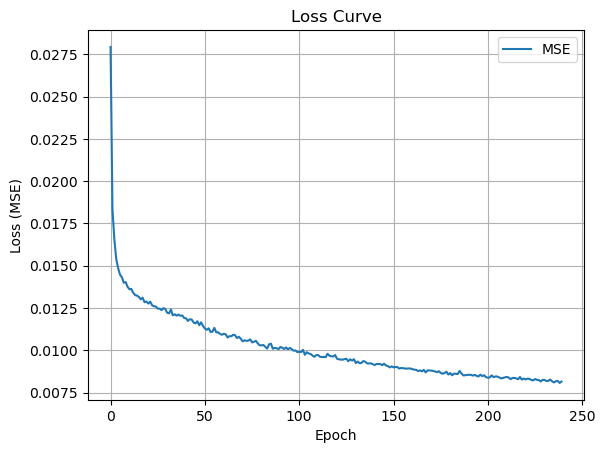

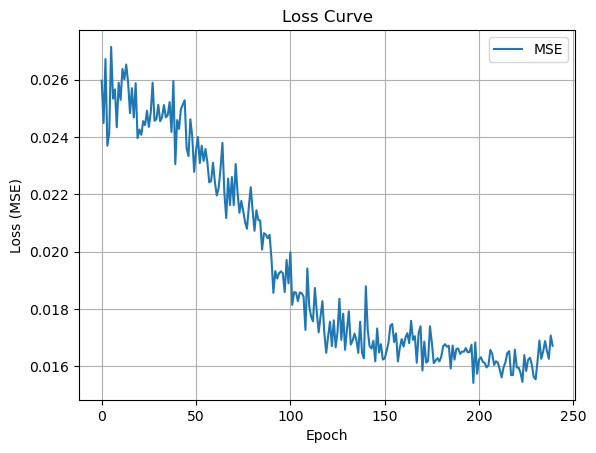

In [24]:
# Training
model = PlacementGNN(13, 64, 4, 5, 'gcn').to(device)
train_wrapper(model, train_dataset, test_dataset)

In [25]:
infer_wrapper(model, train_dataset, test_dataset, clustering_mode=1)

Saved ./pred/gcd_nangate45_gcd_run_1_4_2_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_3_1_2_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_4_2_2_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_5_5_1_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_2_5_3_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_3_4_4_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_1_1_4_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_2_3_2_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_3_4_1_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_1_1_1_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_4_4_3_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_1_2_3_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_5_5_4_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_3_5_4_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_5_4_1_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_2_4_3_predictions.txt
Saved ./pred/gcd_nangate45_gcd_run_4_3_2_predictions.txt
Saved ./pred/gcd_nangate45_gcd_

In [40]:
!tar -czvf "./pred.tar.gz" "./pred/"

./pred/
./pred/gcd_nangate45_gcd_run_4_2_3_predictions.txt
./pred/gcd_nangate45_gcd_run_2_5_4_predictions.txt
./pred/gcd_nangate45_gcd_run_5_5_4_predictions.txt
./pred/gcd_nangate45_gcd_run_3_2_3_predictions.txt
./pred/gcd_nangate45_gcd_run_1_1_2_predictions.txt
./pred/gcd_nangate45_gcd_run_4_4_2_predictions.txt
./pred/gcd_nangate45_gcd_run_4_1_4_predictions.txt
./pred/gcd_nangate45_gcd_run_1_4_4_predictions.txt
./pred/gcd_nangate45_gcd_run_4_3_1_predictions.txt
./pred/gcd_nangate45_gcd_run_3_4_2_predictions.txt
./pred/gcd_nangate45_gcd_run_3_3_1_predictions.txt
./pred/gcd_nangate45_gcd_run_3_1_4_predictions.txt
./pred/gcd_nangate45_gcd_run_3_5_1_predictions.txt
./pred/gcd_nangate45_gcd_run_3_2_2_predictions.txt
./pred/gcd_nangate45_gcd_run_1_2_4_predictions.txt
./pred/gcd_nangate45_gcd_run_4_5_1_predictions.txt
./pred/gcd_nangate45_gcd_run_4_2_2_predictions.txt
./pred/gcd_nangate45_gcd_run_5_1_1_predictions.txt
./pred/gcd_nangate45_gcd_run_5_3_4_predictions.txt
./pred/gcd_nangate45_gc

In [ ]:
# Run: tar -czvf pred.tar.gz pred/
# Transfer and untar: tar -xzvf pred.tar.gz

In [42]:
!conda env export > environment.yml

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(182): Could not remove or rename /opt/conda/conda-meta/protobuf-4.25.3-py311h7b78aeb_0.json.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(182): Could not remove or rename /opt/conda/conda-meta/requests-2.31.0-pyhd8ed1ab_0.json.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(182): Could not remove or rename /opt/conda/conda-meta/tqdm-4.66.2-pyhd8ed1ab_0.json.  Please remove this file manually (you may need to reboot to free file handles)
